In [1]:
import numpy as np # for linear algebra
import pandas as pd # for data visuals and analysis
import keras # for nearual nets and training
import tensorflow as tf # for neaural nets and training
import matplotlib.pyplot as plt # for data visualization
#import dicom # to read dicom files 
import zipfile as zf
from sklearn.datasets import load_files    
from keras.utils import np_utils
import cv2 
import os

Using TensorFlow backend.


Load dataset from train directory

In [2]:
train_dir = "/train/train"

def load_dataset(path):
    data = load_files(path)
    plant_files = np.array(data['filenames'])
    plant_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return plant_files, plant_targets

def load_dir(path):
    data = load_files(path)
    plant_files = np.array(data['filenames'])
    return plant_files

train_files, train_targets = load_dataset('/train/train')

n_classes = train_targets

dir_list = load_dir(train_dir)

Organize images and get all their diemnsions

In [ ]:
from PIL import Image

train_images = []
img_class = []
img_height = []
img_width = []
dir_list = load_dir(train_dir)

for c, files in zip(n_classes, dir_list):    
        img = Image.open(files)
        train_images.append(img)        
        img_class.append(files)
        img_height.append(img.height)
        img_width.append(img.width)
df_all = pd.DataFrame({"class": img_class, "height": img_height, "width": img_width}, index = train_images)

df_all.head()

## Pre Process Image

In [3]:
#IMAGE MASKING
def plant_mask(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

#IMAGE SEGMENTING
def seg_plant(image):
    mask = plant_mask(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

#SHARPENING THE SEGMENTED IMAGE
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

mask_images = [] #Store all masked images
sharpened_images = [] #Store all sharpened images
segmented_images = [] #Store all segmented images
original_images = [] # Store all original resized images
labels = [] # Store all labels

img_size = 75


for i in dir_list: #For i in number of images
    
    image = cv2.imread(i) #Read every image using cv2.imread()
    
    head, tail = os.path.split(os.path.split(i)[0])#Take the path of the image, split it and the name of the class is tail
    
    labels.append(tail) #append the name of the class to labels
    
    resized = cv2.resize(image, (img_size, img_size)) #Resize every image to 50 by 50
    
    image_mask = plant_mask(resized)  # mask the resized image
    image_segmented = seg_plant(resized) # segment the resized image
    image_sharpen = sharpen_image(image_segmented) # sharpen the segmented image
    mask_images.append(image_mask)
    sharpened_images.append(image_sharpen)
    segmented_images.append(image_segmented)
    original_images.append(resized)
    

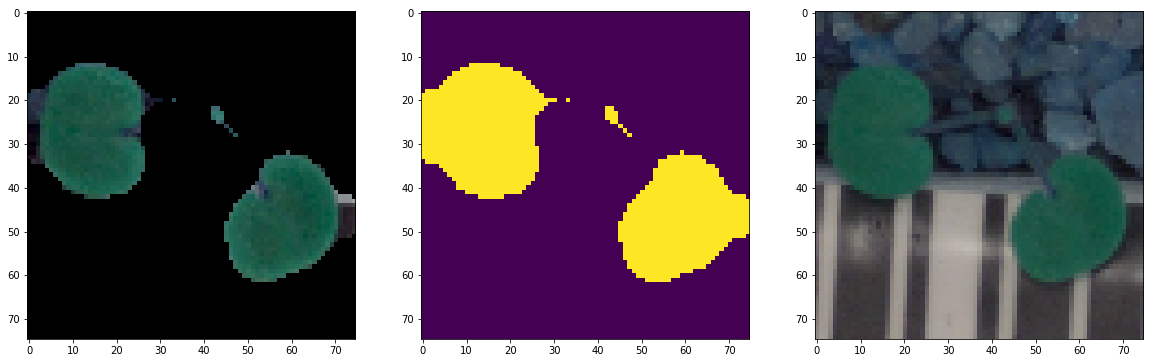

Maize


In [5]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20))
axs[0].imshow(sharpened_images[3])
axs[1].imshow(mask_images[3])
axs[2].imshow(original_images[3])
plt.show()
print(labels[5])

## Organize

Save images to local folder to avoid re-pre-processing which consumes a lot of time.

In [ ]:
path_sharpened = 'C:\\Users\\Aditya Pratap\\Desktop\\Machine Learning\\Pre-processed Images\\sharpened images'

a = -1
for x in (sharpened_images):
    cv2.imwrite(os.path.join(path_sharpened, 'image' + str(a+1) + '.png'), x)
    a = a+1


In [ ]:
#Bring the saved images in folder and save the images in train_segmented_images array to use in model
image_dir = 'C:\\Users\\Aditya Pratap\\Desktop\\Machine Learning\\Pre-processed Images\\sharpened images'

file_dir = load_dir(image_dir)

train_segmented_images = [] #save the sharpened, segmented images to this array
for x in file_dir:
        im = cv2.imread(x)
        train_segmented_images.append(im)

print(len(train_segmented_images))

##### Binarize Lables so model does not take words but binarized numbers

In [6]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer().fit(labels)
label = lb.transform(labels)
print(label)

[[0 0 0 ..., 1 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [7]:
from sklearn.cross_validation import train_test_split

#Training and validation split ---> using np_sharpened_images for training images
x_train, x_valid, y_train, y_valid = train_test_split(sharpened_images, label, test_size = 0.15, random_state = 42)


/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
print(len(x_train))


4037


## Model Definition, Training and Testing

In [9]:
#will NOT be using Image augmentation because training takes extremely long and i dont have a lot of GPU Hours left 
#on my GPU subscription (FloydHub). However, I do understand that Image augmentation will help INCREASE my acuracy.

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=180,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically 
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True  # randomly flip images vertically
    )  
datagen.fit(x_train)

In [10]:
import numpy
import time
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization

seed = 7

numpy.random.seed(seed)

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(img_size, img_size, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(12, activation='softmax'))

model.summary()

# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 73, 73, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 35, 35, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        18496     
__________

In [23]:
t0 = time.time()

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

# learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_loss', patience=6, verbose=0, mode='auto')



callbacks_list = [learning_rate_reduction]



x_train = np.array(x_train)
y_train = np.array(y_train)

x_valid = np.array(x_valid)
y_valid = np.array(y_valid)

# fit model
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 75),
                           epochs=7, validation_data=(x_valid, y_valid),
                           steps_per_epoch = x_train.shape[0], callbacks=callbacks_list)

t1 = time.time()

total = t1-t0

print(total)

Epoch 1/7
4037/4037 [==============================] - 552s - loss: 0.0100 - acc: 0.9967 - val_loss: 0.2266 - val_acc: 0.9593
Epoch 2/7
4037/4037 [==============================] - 552s - loss: 0.0099 - acc: 0.9967 - val_loss: 0.2283 - val_acc: 0.9593
Epoch 3/7
4037/4037 [==============================] - 552s - loss: 0.0096 - acc: 0.9967 - val_loss: 0.2319 - val_acc: 0.9607
Epoch 4/7
4037/4037 [==============================] - 552s - loss: 0.0094 - acc: 0.9968 - val_loss: 0.2329 - val_acc: 0.9579
Epoch 5/7
4037/4037 [==============================] - 552s - loss: 0.0100 - acc: 0.9967 - val_loss: 0.2365 - val_acc: 0.9593
Epoch 6/7
4037/4037 [==============================] - 551s - loss: 0.0096 - acc: 0.9967 - val_loss: 0.2330 - val_acc: 0.9579
Epoch 7/7
4036/4037 [============================>.] - ETA: 0s - loss: 0.0096 - acc: 0.9968
Epoch 00006: reducing learning rate to 1e-05.
4037/4037 [==============================] - 552s - loss: 0.0096 - acc: 0.9968 - val_loss: 0.2358 - val_ac

In [24]:
print(model.evaluate(x_train, y_train))  # Evaluate on train set
print(model.evaluate(x_valid, y_valid))  # Evaluate on test set\

4037/4037 [==============================] - 2s     
[0.00030534346124030297, 1.0]
704/713 [============================>.] - ETA: 0s[0.235778945588623, 0.9579242645105841]


In [25]:
import glob

test_dir = "/train/test"

#LOAD TEST SET FROM FOLDER

sharpened_image_test = []
test_labels = []
for filename in glob.glob('/train/test/*.png'): 
    im = cv2.imread(filename)
    resized_test = cv2.resize(im, (img_size, img_size))
    image_segmented_test = seg_plant(resized_test) #Segment ans sharpen the test set aswell
    image_sharpen_test = sharpen_image(image_segmented_test)
    sharpened_image_test.append(image_sharpen_test)
    head, tail = os.path.split(os.path.split(filename)[1]) #Split the id and ".png" of image
    test_labels.append(tail)
    
x_test = np.array(sharpened_image_test)
yhat = model.predict(x_test)
test_y = lb.inverse_transform(yhat) # SWitch labels from matrices to words



In [26]:
 print(test_y)

['Sugar beet' 'Loose Silky-bent' 'Scentless Mayweed' 'Loose Silky-bent'
 'Scentless Mayweed' 'Sugar beet' 'Loose Silky-bent' 'Common Chickweed'
 'Scentless Mayweed' 'Loose Silky-bent' 'Small-flowered Cranesbill'
 'Charlock' 'Loose Silky-bent' 'Loose Silky-bent' 'Fat Hen'
 'Loose Silky-bent' 'Fat Hen' 'Scentless Mayweed' 'Sugar beet' 'Sugar beet'
 'Charlock' 'Sugar beet' 'Loose Silky-bent' 'Small-flowered Cranesbill'
 'Common Chickweed' 'Common wheat' 'Sugar beet' 'Small-flowered Cranesbill'
 'Charlock' 'Shepherds Purse' 'Loose Silky-bent' 'Fat Hen'
 'Scentless Mayweed' 'Charlock' 'Loose Silky-bent' 'Common Chickweed'
 'Common wheat' 'Scentless Mayweed' 'Cleavers' 'Shepherds Purse' 'Maize'
 'Scentless Mayweed' 'Charlock' 'Common Chickweed' 'Loose Silky-bent'
 'Charlock' 'Loose Silky-bent' 'Loose Silky-bent' 'Common Chickweed'
 'Common Chickweed' 'Small-flowered Cranesbill' 'Shepherds Purse'
 'Cleavers' 'Loose Silky-bent' 'Fat Hen' 'Loose Silky-bent'
 'Shepherds Purse' 'Cleavers' 'Loose 

The prediction for the first image below is Small-flowered Cranesbill


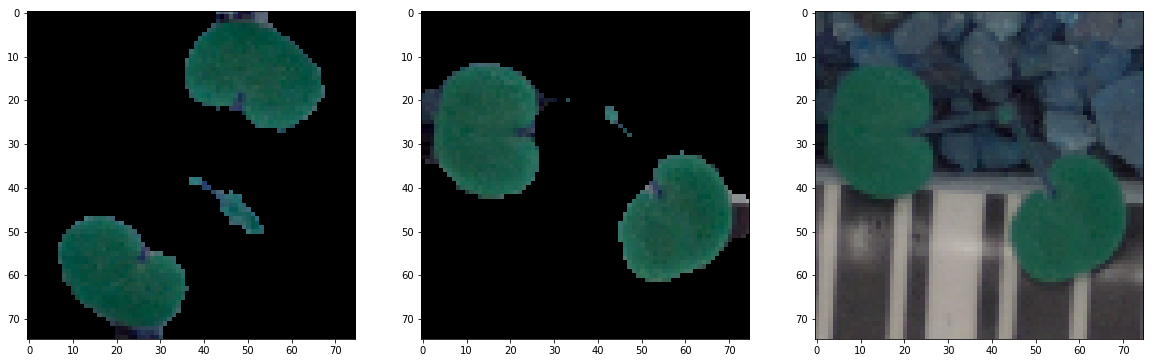

In [27]:
#FOR TESTING, I AM GOING TO USE SMALL-FLOWERED CRANESBILL AS A COMPARISION

print("The prediction for the first image below is", test_y[10]) #Prediction for test set image number 1

fig, axs = plt.subplots(1, 3, figsize=(20, 20))

axs[0].imshow(x_test[10]) #Test image number 1

axs[1].imshow(sharpened_images[3]) #Segmented Image from train set that is labelled Small-flowered Cranesbill

axs[2].imshow(original_images[3]) #original, non-preprocessed Small-flowered Cranesbill from train set itself to show 
                                  #what Small-flowered Cranesbill looks like

plt.show() #IF ALL THE IMAGES BELOW LOOK SIMILAR AND ARE LABELLED SMALL-FLOWER CRANESBILL, 
          #THEN THE MODEL HAS PREDICTED CORRECTLY!
    

In [28]:
import pandas as pd

In [29]:
df = pd.DataFrame(data={'file': test_labels, 'species': test_y})
df_sort = df.sort_values(by=['file'])
df_sort.to_csv('results.csv', index=False)